In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import re
from numpy.random import normal
from scipy.stats import kurtosis, skew
import math
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from six import StringIO 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from IPython.display import Image
import pydotplus
import warnings
warnings.filterwarnings('ignore')

flights = pd.read_csv('final_data.csv', index_col=0)

In [2]:
flights.head()

,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,...,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DELAYED
0,1340,56,128,1436,-13,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1910,155,867,2145,-12,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,630,110,672,820,-8,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,810,100,546,950,152,0,0,0,152,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1000,498,3904,1318,-2,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


### Functions Used for Project

In [50]:
#write function to train and predict model, then print score results 

def model_fit(smotex, smotey, trainx, trainy, testx, testy, model):  
    
    model.fit(smotex, smotey)

    test_prediction = model.predict(testx)
    train_prediction = model.predict(trainx)
    
    print("\n")
    
    print("Train Score Results")
    print(classification_report(trainy, train_prediction))       
    print(f'Train Set Accuracy: {accuracy_score(trainy, train_prediction):.4f}')
    print(f'Train Set Precision: {precision_score(trainy, train_prediction):.4f}')
    print(f'Train Set Recall: {recall_score(trainy, train_prediction):.4f}')
    print(f'Train Set F1-Score: {f1_score(trainy, train_prediction):.4f}')

    print("\n")
    
    print("Test Score Results")    
    print(classification_report(testy, test_prediction))       
    print(f'Test Set Accuracy: {accuracy_score(testy, test_prediction):.4f}')
    print(f'Test Set Precision: {precision_score(testy, test_prediction):.4f}')
    print(f'Test Set Recall: {recall_score(testy, test_prediction):.4f}')
    print(f'Test Set F1-Score: {f1_score(testy, test_prediction):.4f}')
    
    print("\n")
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    trainmatrix = plot_confusion_matrix(model, trainx, trainy, cmap=plt.cm.Blues, ax=ax1)
    testmatrix = plot_confusion_matrix(model, testx, testy, cmap=plt.cm.Blues, ax=ax2)
    ax1.set_title('Train Confusion Matrix')
    ax2.set_title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [3]:
#Create graph that shows the feature importances per tree 
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [4]:
# function for plotting a feature importance histogram (very similar to function above - may not need both)
def features_plot(df, title):
    df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = df, orient = 'h', color = 'blue') \
       .set_title(title, fontsize = 20)

In [5]:
#Function for creating a feature importance dataframe
def features_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

### Train Test Split

In [40]:
y = flights['DELAYED']
X = flights.drop(['DELAYED'], axis=1)

In [41]:
#Investigate the value counts of our y-variable
y.value_counts(normalize=True)

0    0.6284
1    0.3716
Name: DELAYED, dtype: float64

We see that there is quite a bit of a class imbalance in our target variable; 62.8% of our flights were not delayed while only 37.1% were delayed. As a result, we will apply a SMOTE technique in order to create synthesized data in order to improve our model. 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    6284
1    3716
Name: DELAYED, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    4729
0    4729
Name: DELAYED, dtype: int64


In [10]:
X_train_resampled.isna().sum()

SCHEDULED_DEPARTURE                     0
SCHEDULED_TIME                          0
DISTANCE                                0
SCHEDULED_ARRIVAL                       0
ARRIVAL_DELAY                           0
AIR_SYSTEM_DELAY                        0
SECURITY_DELAY                          0
AIRLINE_DELAY                           0
LATE_AIRCRAFT_DELAY                     0
WEATHER_DELAY                           0
AIRLINE_Alaska Airlines Inc.            0
AIRLINE_American Airlines Inc.          0
AIRLINE_American Eagle Airlines Inc.    0
AIRLINE_Atlantic Southeast Airlines     0
AIRLINE_Delta Air Lines Inc.            0
AIRLINE_Frontier Airlines Inc.          0
AIRLINE_Hawaiian Airlines Inc.          0
AIRLINE_JetBlue Airways                 0
AIRLINE_Skywest Airlines Inc.           0
AIRLINE_Southwest Airlines Co.          0
AIRLINE_Spirit Air Lines                0
AIRLINE_US Airways Inc.                 0
AIRLINE_United Air Lines Inc.           0
AIRLINE_Virgin America            

### 1. KNN

In [43]:
#Scale the data
scaler = StandardScaler()  
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

In [44]:
#Fit and predict the vanilla model
knnmodel = KNeighborsClassifier()



Train Score Results
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      4729
           1       0.00      0.00      0.00      2771

    accuracy                           0.63      7500
   macro avg       0.32      0.50      0.39      7500
weighted avg       0.40      0.63      0.49      7500

Train Set Accuracy: 0.6305
Train Set Precision: 0.0000
Train Set Recall: 0.0000
Train Set F1-Score: 0.0000


Test Score Results
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1555
           1       0.00      0.00      0.00       945

    accuracy                           0.62      2500
   macro avg       0.31      0.50      0.38      2500
weighted avg       0.39      0.62      0.48      2500

Test Set Accuracy: 0.6220
Test Set Precision: 0.0000
Test Set Recall: 0.0000
Test Set F1-Score: 0.0000




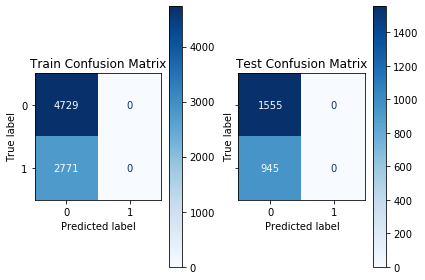

In [51]:
#Apply the model and print metrics
model_fit(X_train_resampled, y_train_resampled, X_train_scaled, y_train, X_test_scaled, y_test, knnmodel)

### 2. Bayes Classification Model

In [17]:
#Instansiate the vanilla model
bayes = GaussianNB()

In [18]:
bayes.fit(X_train_resampled, y_train_resampled)

GaussianNB()



Train Score Results
              precision    recall  f1-score   support

           0       0.75      0.99      0.86      4729
           1       0.97      0.44      0.60      2771

    accuracy                           0.79      7500
   macro avg       0.86      0.72      0.73      7500
weighted avg       0.83      0.79      0.76      7500

Train Set Accuracy: 0.7877
Train Set Precision: 0.9720
Train Set Recall: 0.4381
Train Set F1-Score: 0.6040


Test Score Results
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1555
           1       0.98      0.43      0.60       945

    accuracy                           0.78      2500
   macro avg       0.86      0.71      0.72      2500
weighted avg       0.83      0.78      0.75      2500

Test Set Accuracy: 0.7804
Test Set Precision: 0.9760
Test Set Recall: 0.4296
Test Set F1-Score: 0.5966




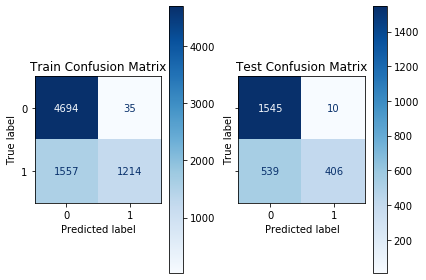

In [19]:
#Apply the modelfit function
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bayes)

### 3. Decision Tree Classifier

In [20]:
#Instansiate the vanilla model 
decisiontree = DecisionTreeClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4729
           1       1.00      1.00      1.00      2771

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0000
Train Set Precision: 1.0000
Train Set Recall: 1.0000
Train Set F1-Score: 1.0000


Test Score Results
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1555
           1       0.64      0.65      0.65       945

    accuracy                           0.73      2500
   macro avg       0.71      0.72      0.71      2500
weighted avg       0.73      0.73      0.73      2500

Test Set Accuracy: 0.7312
Test Set Precision: 0.6432
Test Set Recall: 0.6487
Test Set F1-Score: 0.6459




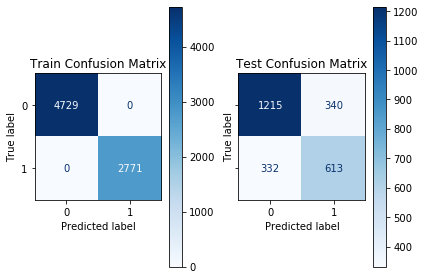

In [21]:
#Apply the model fit function 
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, decisiontree)

In [ ]:
#Code for plotting decision tree


# dot_data = StringIO()
# export_graphviz(decisiontree3, out_file=dot_data,  
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### 4. Ensemble Methods

#### a. Bagging Method

In [22]:
#Instansiate the vanilla model
bagged_tree = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=20)



Train Score Results
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4729
           1       1.00      0.99      0.99      2771

    accuracy                           1.00      7500
   macro avg       1.00      0.99      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 0.9957
Train Set Precision: 0.9993
Train Set Recall: 0.9892
Train Set F1-Score: 0.9942


Test Score Results
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1555
           1       0.79      0.63      0.70       945

    accuracy                           0.80      2500
   macro avg       0.80      0.77      0.78      2500
weighted avg       0.80      0.80      0.79      2500

Test Set Accuracy: 0.7988
Test Set Precision: 0.7931
Test Set Recall: 0.6328
Test Set F1-Score: 0.7039




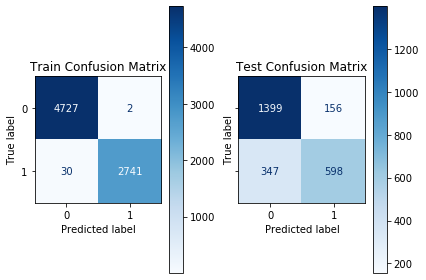

In [23]:
#Apply the model prediction
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, bagged_tree)

#### b. Random Forest

In [24]:
#Instansiate the vanilla model 
randomforest = RandomForestClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4729
           1       1.00      1.00      1.00      2771

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Train Set Accuracy: 1.0000
Train Set Precision: 1.0000
Train Set Recall: 1.0000
Train Set F1-Score: 1.0000


Test Score Results
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1555
           1       0.80      0.66      0.72       945

    accuracy                           0.81      2500
   macro avg       0.80      0.78      0.79      2500
weighted avg       0.81      0.81      0.80      2500

Test Set Accuracy: 0.8064
Test Set Precision: 0.7959
Test Set Recall: 0.6561
Test Set F1-Score: 0.7193




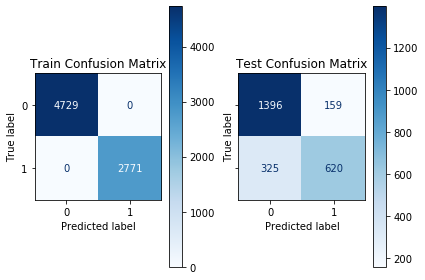

In [25]:
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, randomforest)

In [26]:
#Look at another performance measure: mean 3-Fold cross validation score 
mean_rf_cv_score = np.mean(cross_val_score(randomforest, X_train, y_train, cv=3))
mean_rf_cv_score

0.8092

### 5. Boosting

#### a. Adaboost

In [27]:
#Instansiate the vanilla model
adb = AdaBoostClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4729
           1       0.78      0.69      0.73      2771

    accuracy                           0.81      7500
   macro avg       0.81      0.79      0.79      7500
weighted avg       0.81      0.81      0.81      7500

Train Set Accuracy: 0.8143
Train Set Precision: 0.7847
Train Set Recall: 0.6853
Train Set F1-Score: 0.7317


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1555
           1       0.77      0.68      0.72       945

    accuracy                           0.80      2500
   macro avg       0.79      0.78      0.78      2500
weighted avg       0.80      0.80      0.80      2500

Test Set Accuracy: 0.8016
Test Set Precision: 0.7676
Test Set Recall: 0.6815
Test Set F1-Score: 0.7220




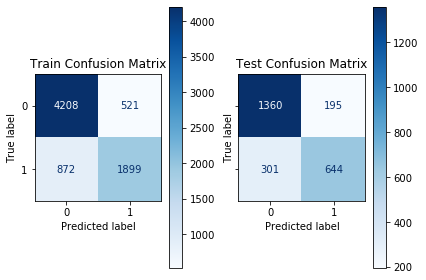

In [28]:
#Fit and predict model and show results
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, adb)

In [29]:
#Look at another performance measure: mean 3-Fold cross validation score 
adb_mean_cv = cross_val_score(adb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {adb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  81.31%


#### b. Gradient Boosting

In [30]:
#Instansiate the vanilla model
gb = GradientBoostingClassifier(random_state=42)



Train Score Results
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4729
           1       0.82      0.70      0.76      2771

    accuracy                           0.83      7500
   macro avg       0.83      0.81      0.81      7500
weighted avg       0.83      0.83      0.83      7500

Train Set Accuracy: 0.8331
Train Set Precision: 0.8228
Train Set Recall: 0.6987
Train Set F1-Score: 0.7557


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1555
           1       0.78      0.68      0.72       945

    accuracy                           0.81      2500
   macro avg       0.80      0.78      0.79      2500
weighted avg       0.80      0.81      0.80      2500

Test Set Accuracy: 0.8052
Test Set Precision: 0.7793
Test Set Recall: 0.6762
Test Set F1-Score: 0.7241




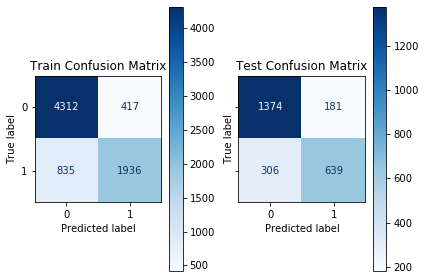

In [31]:
#Fit and predict model and show results
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, gb)

In [32]:
#Look at another performance measure: mean 3-Fold cross validation score 
gb_mean_cv = cross_val_score(gb, X, y, cv=3).mean()

print(f"Mean Adaboost Cross-Val Score (k=3): {gb_mean_cv: .2%}")

Mean Adaboost Cross-Val Score (k=3):  81.68%


#### c. XGBoost

In [33]:
#Instansiate the vanilla model
xgb = XGBClassifier()



Train Score Results
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4729
           1       0.83      0.68      0.75      2771

    accuracy                           0.83      7500
   macro avg       0.83      0.80      0.81      7500
weighted avg       0.83      0.83      0.83      7500

Train Set Accuracy: 0.8305
Train Set Precision: 0.8272
Train Set Recall: 0.6842
Train Set F1-Score: 0.7490


Test Score Results
              precision    recall  f1-score   support

           0       0.82      0.90      0.85      1555
           1       0.80      0.67      0.73       945

    accuracy                           0.81      2500
   macro avg       0.81      0.78      0.79      2500
weighted avg       0.81      0.81      0.81      2500

Test Set Accuracy: 0.8092
Test Set Precision: 0.7955
Test Set Recall: 0.6667
Test Set F1-Score: 0.7254




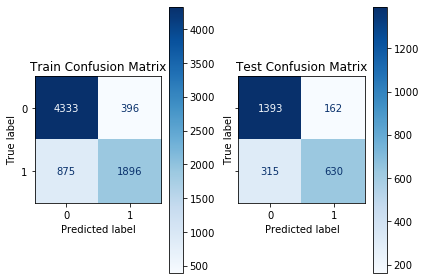

In [34]:
#Fit and predict model and show results
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, xgb)

### 6. Support Vector Machines

In [35]:
#Instansiate the vanilla model
svclassifier = SVC()



Train Score Results
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      4729
           1       0.65      0.59      0.62      2771

    accuracy                           0.73      7500
   macro avg       0.71      0.70      0.71      7500
weighted avg       0.73      0.73      0.73      7500

Train Set Accuracy: 0.7320
Train Set Precision: 0.6520
Train Set Recall: 0.5890
Train Set F1-Score: 0.6189


Test Score Results
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1555
           1       0.65      0.59      0.62       945

    accuracy                           0.72      2500
   macro avg       0.71      0.70      0.70      2500
weighted avg       0.72      0.72      0.72      2500

Test Set Accuracy: 0.7232
Test Set Precision: 0.6459
Test Set Recall: 0.5926
Test Set F1-Score: 0.6181




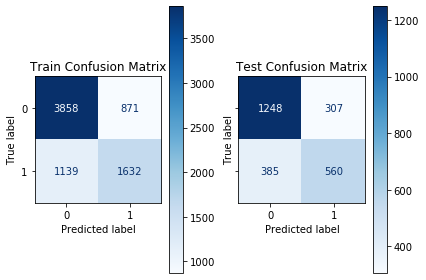

In [36]:
#Fit and predict model and show results
model_fit(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, svclassifier)

### All Vanilla Results

In [ ]:
#Function used to print results in one place, then use this to build table 

def model_results(smotex, smotey, trainx, trainy, testx, testy, model, name):  
    
    model.fit(smotex, smotey)

    test_prediction = model.predict(testx)
    train_prediction = model.predict(trainx)
    
    result = {'model': name}
    
    result['train_accuracy'] = accuracy_score(trainy, train_prediction)
    result['train_precision'] = precision_score(trainy, train_prediction)
    result['train_recall'] = recall_score(trainy, train_prediction)
    result['train_f1'] = f1_score(trainy, train_prediction)
    
    result['test_accuracy'] = accuracy_score(testy, test_prediction)
    result['test_precision'] = precision_score(testy, test_prediction)
    result['test_recall'] = recall_score(testy, test_prediction)
    result['test_f1'] = f1_score(testy, test_prediction)
    
    
    return result

In [75]:
# KNN Result 
knnresult = model_results(X_train_resampled, y_train_resampled, X_train_scaled, y_train, X_test_scaled, 
                          y_test, knnmodel, 'knn')

#Bayes Result
bayesresult = model_results(X_train_resampled, y_train_resampled, X_train, y_train, X_test, 
                            y_test, bayes, 'bayes')

#Decision Tree Result
decisiontreeresult = model_results(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, 
                                   decisiontree, 'decisiontree')

#Bagging Result
baggingresult = model_results(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, 
                                   bagged_tree, 'bagging')

#Random Forest Result 
randomforestresult = model_results(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, 
                                   randomforest, 'randomforest')

#Adaboost Result
adbresult = model_results(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, 
                          adb, 'adaboost')

#XGB Result
xgbresult = model_results(X_train_resampled, y_train_resampled, X_train, y_train, X_test, y_test, 
                          xgb, 'XGBoost')

#SVM Result
svmresult = model_results(X_train_resampled, y_train_resampled, X_train, y_train, 
                          X_test, y_test, svclassifier, 'SVM')

In [79]:
result_list = [knnresult, bayesresult, decisiontreeresult, baggingresult, 
                randomforestresult, adbresult, xgbresult, svmresult]

In [90]:
df_results = pd.DataFrame.from_dict(result_list, orient='columns')
df_results = df_results.set_index('model')

In [91]:
df_results

,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,,,
knn,0.630533,0.000000,0.000000,0.000000,0.6220,0.000000,0.000000,0.000000
bayes,0.787733,0.971978,0.438109,0.603980,0.7804,0.975962,0.429630,0.596620
decisiontree,1.000000,1.000000,1.000000,1.000000,0.7312,0.643232,0.648677,0.645943
bagging,0.996400,0.998909,0.991339,0.995110,0.7912,0.777924,0.626455,0.694021
randomforest,1.000000,1.000000,1.000000,1.000000,0.8064,0.795892,0.656085,0.719258
adaboost,0.814267,0.784711,0.685312,0.731651,0.8016,0.767580,0.681481,0.721973
XGBoost,0.830533,0.827225,0.684230,0.748963,0.8092,0.795455,0.666667,0.725389
SVM,0.732000,0.652018,0.588957,0.618885,0.7232,0.645905,0.592593,0.618102
